<a href="https://colab.research.google.com/github/Esperance98/ASSIGN2/blob/master/LULC_RW_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Land use/ Land cover segmentation

In [ ]:
!pip install rasterio onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 63.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

import rasterio as rio
from rasterio.merge import merge,
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm
from glob import glob
import os
import shutil

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

#Google Drive
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Device and torch version

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)
print("PyTorch version:", torch.__version__)

Device: cuda
PyTorch version: 2.0.1+cu118


### Dataset

In [ ]:
# Extract dataset from the zip file on google drive
!unzip -q '/content/drive/MyDrive/Colab Notebooks/combined_data.zip' -d '/content'

In [ ]:
dataset_folder = 'Combined_data'
train_folder = 'training'
test_folder = 'testing'

test_ratio = 0.2 # train-test split ratio

# Create the training and testing folders
os.makedirs(train_folder+'/images', exist_ok=True)
os.makedirs(train_folder+'/masks', exist_ok=True)

os.makedirs(test_folder+'/images', exist_ok=True)
os.makedirs(test_folder+'/masks', exist_ok=True)

In [ ]:
# Get the list of image and mask filenames
image_folder = os.path.join(dataset_folder, 'images')
mask_folder = os.path.join(dataset_folder, 'masks')

image_filenames = os.listdir(image_folder)
mask_filenames = os.listdir(mask_folder)
print(f'Total images: {len(image_filenames)}')

# Sort the filenames to ensure consistent splitting
image_filenames.sort()
mask_filenames.sort()

# Check if the number of images and masks are the same
if len(image_filenames) != len(mask_filenames):
    print("Number of images and masks do not match!")
    exit(1)


Total images: 1313


In [ ]:
data = list(zip(image_filenames, mask_filenames))  # Create a list of tuples containing the image and mask filenames

random.seed(42)  # for reproducibility
random.shuffle(data)  # Randomly shuffle the data

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=test_ratio)

# Move the training data to the train_folder
for image_filename, mask_filename in train_data:
    shutil.move(os.path.join(image_folder, image_filename), train_folder+'/images')
    shutil.move(os.path.join(mask_folder, mask_filename), train_folder+'/masks')

# Move the testing data to the test_folder
for image_filename, mask_filename in test_data:
    shutil.move(os.path.join(image_folder, image_filename), test_folder+'/images')
    shutil.move(os.path.join(mask_folder, mask_filename), test_folder+'/masks')


In [ ]:
# Transformation for normalizing and converting the image to tensor
image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),

])

In [ ]:
class Segmentation_dataset(Dataset):
    def __init__(self, folder_path, augment=True):
        super(Segmentation_dataset, self).__init__()
        self.img_files = glob(os.path.join(folder_path, 'images', '*.jpg'))
        self.mask_files = []
        self.augment = augment

        for img_path in self.img_files:
            self.mask_files.append(os.path.join(folder_path, 'masks', os.path.basename(img_path[:-3]+'png')))

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        label = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        if self.augment:
            image, label = self.apply_augmentation(image, label)

        data = {'image': image_transform(image), 'mask':  torch.squeeze((target_transform(label))*255).long()}
        return data

    def __len__(self):
        return len(self.img_files)

    def apply_augmentation(self, image, label):
        # Randomly apply data augmentation techniques to the image and mask

        if random.random() > 0.5:
            angle = random.randint(-30, 30)
            image__=transforms.ToPILImage()(image)
            label__=transforms.ToPILImage()(label)
            image = transforms.functional.rotate(image__, angle)
            label = transforms.functional.rotate(label__, angle)

        if random.random() > 0.5:
            image_=np.array(image)
            label_=np.array(label)
            image = cv2.flip(image_, 1)
            label = cv2.flip(label_, 1)

        return np.array(image), np.array(label)


In [ ]:
train_dataset = Segmentation_dataset('training', augment=True)
test_dataset = Segmentation_dataset('testing', augment=False)

In [ ]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)


Image shape: torch.Size([3, 224, 224])
Mask shape: torch.Size([224, 224])



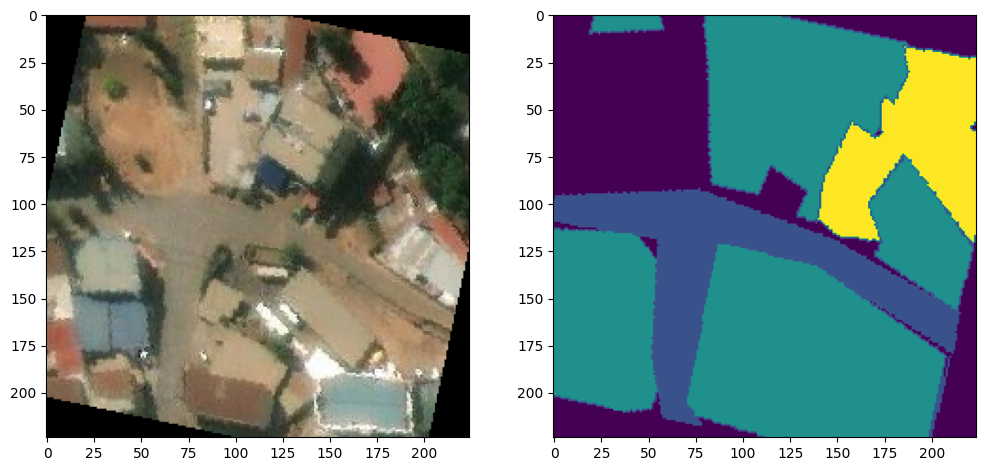

In [ ]:
for data in train_dataset:
    x, y = data["image"],data["mask"]
    print(f'Image shape: {x.shape}\nMask shape: {y.shape}')
    print()
    fig, ax = plt.subplots(1,2, figsize=(12,10))
    ax[0].imshow(inv_normalize(x.cpu()).permute(1, 2, 0))
    ax[1].imshow(y.cpu())
    break

### Dataloader

In [ ]:
train_dloader    = DataLoader(
                        train_dataset,
                        batch_size=16,
                        shuffle=True
                        )
val_dloader      = DataLoader(
                        test_dataset,
                        batch_size=8,
                        shuffle=False
                        )

### Helper functions

In [ ]:
def merge_files(files):

    rasters = [ rio.open(f) for f in files ]
    mosaic, trans = merge(rasters)

    # Get metadata from the first raster
    meta = rasters[0].meta.copy()

    # Update metadata with mosaic shape and transform
    meta.update({
        'height': mosaic.shape[1],
        'width': mosaic.shape[2],
        'transform': trans
    })

    # Close all opened rasters
    for raster in rasters:
        raster.close()

    return mosaic, meta


In [ ]:
def save_merged(mosaic, meta, out_path):

    with rio.open(out_path, 'w', **meta) as dst:
        dst.write(mosaic)


In [ ]:
def create_image_from_patches(patches_path, out_path):

    patches_names = glob(os.path.join(patches_path,"*.tif"))
    mosaic, meta = merge_files(patches_names)
    save_merged(mosaic=mosaic, meta=meta, out_path=out_path)

In [ ]:
def resnet_backbone(name, pretrained):
  try:
    if name == 'resnet50':
        backbone = models.resnet50(pretrained=pretrained)
    elif name == 'resnet101':
          backbone = models.resnet101(pretrained=pretrained)
    elif name == 'resnet152':
          backbone = models.resnet152(pretrained=pretrained)
    return backbone
  except:
    print(f'{name} not found!\n backbone must be resnet50, resnet101 or resnet152')

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print(f'Model total parameters: {sum(params):>6}')

In [ ]:
def upconv(ch_in, ch_out, kernel_size=(3, 3),stride=1, padding=1):
  return nn.Sequential(
      nn.Conv2d(in_channels=ch_in, out_channels=ch_out, kernel_size=kernel_size,
                               stride=stride, padding=padding),
      nn.ReLU(inplace=True),
  )


#### Model architecture

In [ ]:
class Unet_resnet(nn.Module):

    def __init__(self, n_class,
                 backbone_name,
                 pretrained=True
                 ):
        super().__init__()

        self.backbone_name = backbone_name
        self.backbone = resnet_backbone(backbone_name, pretrained=pretrained)

        self.layer0 = nn.Sequential(*list(self.backbone.children())[:3])
        self.layer1 = nn.Sequential(*list(self.backbone.children())[3:5])
        self.layer2 = self.backbone.layer2
        self.layer3 = self.backbone.layer3
        self.layer4 = self.backbone.layer4

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_up3 = upconv(3072, 2048, 3, 1) # 1024 + 2048, 2048
        self.conv_up2 = upconv(2560, 1024, 3, 1) # 512 + 2048, 1024
        self.conv_up1 = upconv(1280, 512, 3, 1) # 256 + 1024, 512
        self.conv_up0 = upconv(576, 256, 3, 1) # 64 + 512, 256

        self.conv_original_size0 = upconv(3, 64, 3, 1)
        self.conv_original_size1 = upconv(64, 64, 3, 1)
        self.conv_original_size2 = upconv(320, 64, 3, 1) # 64 + 256, 64

        self.final_conv = nn.Conv2d(64, n_class, 1)


    def forward(self, input):
      x_original = self.conv_original_size0(input)
      x_original = self.conv_original_size1(x_original)

      layer0 = self.layer0(input)
      layer1 = self.layer1(layer0)
      layer2 = self.layer2(layer1)
      layer3 = self.layer3(layer2)
      layer4 = self.layer4(layer3)

      x = self.upsample(layer4)
      x = torch.cat([x, layer3], dim=1)
      x = self.conv_up3(x)

      x = self.upsample(x)
      x = torch.cat([x, layer2], dim=1)
      x = self.conv_up2(x)

      x = self.upsample(x)
      x = torch.cat([x, layer1], dim=1)
      x = self.conv_up1(x)

      x = self.upsample(x)
      x = torch.cat([x, layer0], dim=1)
      x = self.conv_up0(x)

      x = self.upsample(x)
      x = torch.cat([x, x_original], dim=1)
      x = self.conv_original_size2(x)

      out = self.final_conv(x)

      return out


### Loss function

In [ ]:
ce = nn.CrossEntropyLoss()

def cEntropy_Loss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

### Model Training and evaluation

In [ ]:
n_class=5

In [ ]:
model = Unet_resnet(n_class=n_class,
                backbone_name='resnet50'
                ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Total number of parameters in the model
count_parameters(model)

Model total parameters: 113225839


In [ ]:
# Initialize variables for early stopping
best_val_loss = float('inf')
patience = 10
counter = 0  # Counter for epochs without improvement

# Training and validation losses and accuracy list
train_loss_avg = []
val_loss_avg = []

train_acc_avg = []
val_acc_avg = []


In [ ]:
%%time
for epoch in range(50):
    print(f"       Epoch: {epoch}   \n   ******************   ")

    # Training
    model.train()
    train_losses = []
    train_accs = []
    for bx, data in tqdm(enumerate(train_dloader), total=len(train_dloader)):
        ims, ce_masks = data["image"].to(device),data["mask"].type(torch.LongTensor).to(device)
        pred_masks = model(ims)

        optimizer.zero_grad()
        loss, acc = cEntropy_Loss(pred_masks, ce_masks)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        train_accs.append(acc.item())

    train_loss_avg.append(np.mean(train_losses))
    train_acc_avg.append(np.mean(train_accs))

    # Validation
    model.eval()
    val_losses = []
    val_accs = []

    with torch.no_grad():
      for bx, data in tqdm(enumerate(val_dloader), total=len(val_dloader)):
          val_ims, val_masks = data["image"].to(device),data["mask"].type(torch.LongTensor).to(device)

          pred_masks = model(val_ims)
          loss, acc = cEntropy_Loss(pred_masks, val_masks)
          val_losses.append(loss.item())
          val_accs.append(acc.item())

      if np.mean(val_losses) < best_val_loss:
          best_val_loss = np.mean(val_losses)
          counter = 0
          torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/models/LULC_RW_resnet50_V2.pth')  # Save the best model
      else:
          counter += 1

      # Check if training should be stopped
      if counter >= patience:
          print(f"Early stopping at epoch {epoch}.")
          break

      val_loss_avg.append(np.mean(val_losses))
      val_acc_avg.append(np.mean(val_accs))

      print(f"Train loss: {train_loss_avg[epoch]:.4f}\tTrain acc: {train_acc_avg[epoch]:.4f}\tVal loss: {val_loss_avg[epoch]:.4f}\tVal acc: {val_acc_avg[epoch]:.4f}\n")

       Epoch: 0   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.86it/s]


Train loss: 1.5643	Train acc: 0.3688	Val loss: 1.3489	Val acc: 0.5127

       Epoch: 1   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.89it/s]


Train loss: 1.0685	Train acc: 0.6120	Val loss: 0.9107	Val acc: 0.6515

       Epoch: 2   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.91it/s]


Train loss: 0.8633	Train acc: 0.6732	Val loss: 0.8513	Val acc: 0.6801

       Epoch: 3   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


Train loss: 0.8458	Train acc: 0.6734	Val loss: 0.8254	Val acc: 0.7006

       Epoch: 4   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.85it/s]


Train loss: 0.7551	Train acc: 0.7114	Val loss: 0.7893	Val acc: 0.7141

       Epoch: 5   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


Train loss: 0.7222	Train acc: 0.7177	Val loss: 0.8024	Val acc: 0.7085

       Epoch: 6   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


Train loss: 0.6960	Train acc: 0.7269	Val loss: 0.8776	Val acc: 0.6981

       Epoch: 7   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Train loss: 0.6518	Train acc: 0.7376	Val loss: 0.7945	Val acc: 0.6973

       Epoch: 8   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]


Train loss: 0.6512	Train acc: 0.7502	Val loss: 0.7528	Val acc: 0.7265

       Epoch: 9   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.74it/s]


Train loss: 0.5895	Train acc: 0.7657	Val loss: 0.7483	Val acc: 0.7219

       Epoch: 10   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


Train loss: 0.5788	Train acc: 0.7768	Val loss: 0.7615	Val acc: 0.7371

       Epoch: 11   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.71it/s]


Train loss: 0.5603	Train acc: 0.7855	Val loss: 0.7585	Val acc: 0.7443

       Epoch: 12   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.72it/s]


Train loss: 0.5515	Train acc: 0.7974	Val loss: 0.8442	Val acc: 0.6936

       Epoch: 13   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.75it/s]


Train loss: 0.5009	Train acc: 0.8178	Val loss: 0.8117	Val acc: 0.7235

       Epoch: 14   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.72it/s]


Train loss: 0.5828	Train acc: 0.7698	Val loss: 0.7180	Val acc: 0.7419

       Epoch: 15   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.77it/s]


Train loss: 0.4533	Train acc: 0.8329	Val loss: 0.8697	Val acc: 0.7191

       Epoch: 16   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.68it/s]


Train loss: 0.4713	Train acc: 0.8332	Val loss: 0.9046	Val acc: 0.7301

       Epoch: 17   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.74it/s]


Train loss: 0.5038	Train acc: 0.8228	Val loss: 0.7350	Val acc: 0.7410

       Epoch: 18   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.75it/s]


Train loss: 0.4514	Train acc: 0.8378	Val loss: 0.7733	Val acc: 0.7380

       Epoch: 19   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.72it/s]


Train loss: 0.4205	Train acc: 0.8525	Val loss: 0.7855	Val acc: 0.7470

       Epoch: 20   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.71it/s]


Train loss: 0.3770	Train acc: 0.8667	Val loss: 0.8389	Val acc: 0.7312

       Epoch: 21   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


Train loss: 0.3567	Train acc: 0.8720	Val loss: 0.8812	Val acc: 0.7181

       Epoch: 22   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.71it/s]


Train loss: 0.3650	Train acc: 0.8694	Val loss: 0.7728	Val acc: 0.7596

       Epoch: 23   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.68it/s]


Train loss: 0.3327	Train acc: 0.8801	Val loss: 0.7766	Val acc: 0.7604

       Epoch: 24   
   ******************   


100%|██████████| 13/13 [00:03<00:00,  3.77it/s]

Early stopping at epoch 24.
CPU times: user 12min 57s, sys: 7.08 s, total: 13min 4s
Wall time: 13min 34s


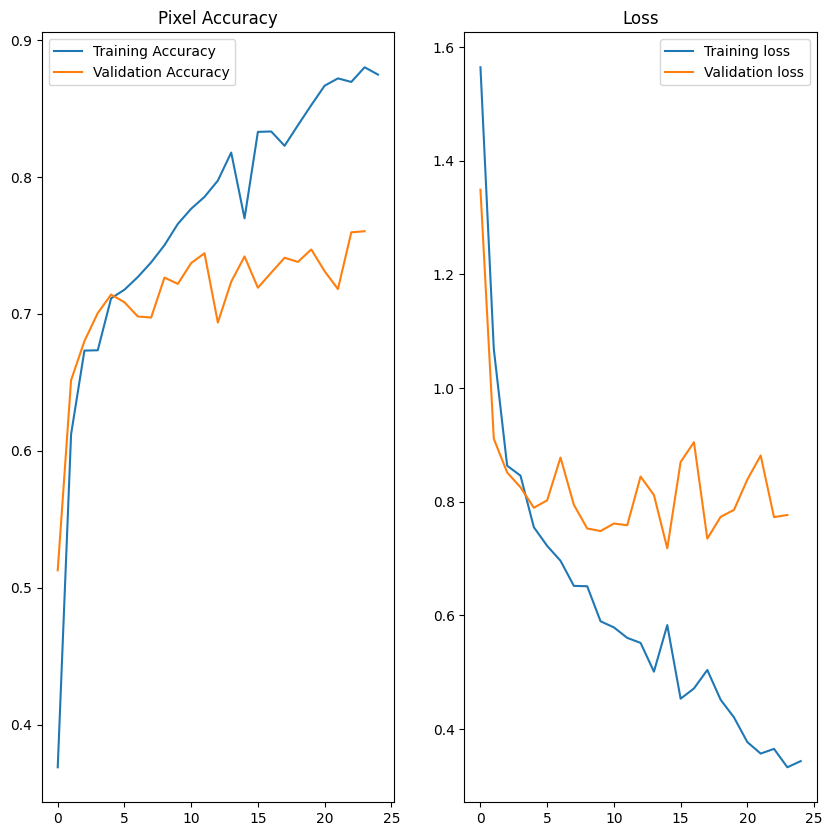

In [ ]:
plt.figure(figsize=(10, 10))
# Plot accuracy
plt.subplot(121)
plt.plot(train_acc_avg, label='Training Accuracy')
plt.plot(val_acc_avg, label='Validation Accuracy')
plt.title("Pixel Accuracy")
plt.legend()

# Plot the loss
plt.subplot(122)
plt.plot(train_loss_avg, label='Training loss')
plt.plot(val_loss_avg, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.show()

### Load weights

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/models/LULC_RW_resnet50_V2.pth'

In [ ]:
# Load model
Loaded_model = Unet_resnet(n_class=n_class,
                backbone_name='resnet50'
                ).to(device)

Loaded_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
# Extract dataset from the zip file on google drive
!unzip -q '/content/drive/MyDrive/Colab Notebooks/image_tiles_1164.zip' -d '/content'

In [ ]:
# get each tile name
tile_names = glob(os.path.join('image_tiles_1164',"*.tif"))
# Number of tiles
len(tile_names)

15625

In [ ]:
# Transformation for normalizing and converting the image to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
# Create directory to store predicted masks
!mkdir predictions

In [ ]:
# Prediction
Loaded_model.eval()
with torch.no_grad():
    for image in tile_names:
        mask_name = image.split('/')[-1]
        image_ = cv2.imread(image)
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        with rio.open(image) as tile:
            val_im = transform(image_).to(device)
            pred_mask_ = Loaded_model(torch.unsqueeze(val_im,0))
            pred_mask_ = torch.argmax(pred_mask_[0], dim=0).cpu().numpy()

            with rio.Env():
                profile = tile.profile
                profile.update(
                    dtype=rio.uint8,
                    count=1,
                    compress='lzw')

                with rio.open(f'predictions/{mask_name}', 'w', **profile) as dst:
                    dst.write(pred_mask_.astype(rio.uint8), 1)



In [ ]:
# Set output path
output_folder_mergedTiles = '/content/drive/MyDrive/Colab Notebooks/mask_merged'
out_path = os.path.join(output_folder_mergedTiles, 'mask1164_newM_mb_v2.tif')

In [ ]:
# Merge and save the patches
create_image_from_patches(patches_path='./predictions', out_path=out_path)

In [ ]:
def convert(path):
  """
  Convert pytorch model to onnx
  """
    dummy_input = torch.randn(1, 3, 224, 224, requires_grad=True).to(device)
    Loaded_model.eval() # set the model to inference mode

    # Export the model
    torch.onnx.export(Loaded_model,
         dummy_input,
         path,
         export_params=True,
         opset_version=11,    # the ONNX version to export the model to
         do_constant_folding=True,  # whether to execute constant folding for optimization
         input_names = ['input'],
         output_names = ['output'],
         dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                       'output' : {0 : 'batch_size'}})

In [ ]:
convert("/content/drive/MyDrive/Colab Notebooks/models/LULC_RW_resnet50_V2.onnx")

###End!